# Draw an isochrone map with OSMnx

Author: [Geoff Boeing](https://geoffboeing.com/)

How far can you travel on foot in 15 minutes?

  - [Documentation](https://osmnx.readthedocs.io/)
  - [Journal article and citation info](https://doi.org/10.1111/gean.70009)
  - [Code repository](https://github.com/gboeing/osmnx)
  - [Examples gallery](https://github.com/gboeing/osmnx-examples)

In [2]:
#!uv pip install --system --quiet osmnx[all]
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from shapely.geometry import LineString, Point, Polygon

ox.__version__

'2.0.7'

In [3]:
# configure the place, network type, trip times, and travel speed
place = {"city": "London", "state": "England"}
network_type = "walk"
trip_times = [5, 10, 15, 20, 25]  # in minutes
travel_speed = 4.5  # walking speed in km/hour

## Download and prep the street network

In [4]:
# download the street network
G = ox.graph.graph_from_place(place, network_type=network_type)

In [5]:
# find the centermost node and then project the graph to UTM
gdf_nodes = ox.convert.graph_to_gdfs(G, edges=False)
x, y = gdf_nodes["geometry"].union_all().centroid.xy
center_node = ox.distance.nearest_nodes(G, x[0], y[0])
G = ox.projection.project_graph(G)

In [6]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute
for _, _, _, data in G.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute

## Plots nodes you can reach on foot within each time

How far can you walk in 5, 10, 15, 20, and 25 minutes from the origin node? We'll use NetworkX to induce a subgraph of G within each distance, based on trip time and travel speed.

In [7]:
# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0)

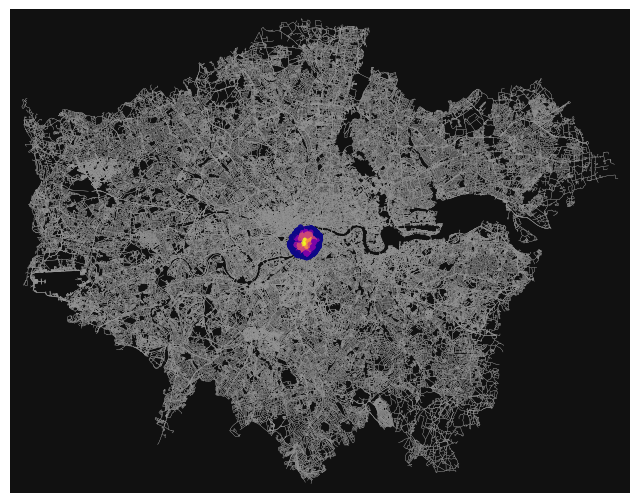

In [8]:
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors.get(node, "none") for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot.plot_graph(
    G,
    node_color=nc,
    node_size=ns,
    node_alpha=0.8,
    edge_linewidth=0.2,
    edge_color="#999999",
)

## Plot the time-distances as isochrones

How far can you walk in 5, 10, 15, 20, and 25 minutes from the origin node? We'll use a convex hull, which isn't perfectly accurate. A concave hull would be better, but shapely doesn't offer that.

In [9]:
# make the isochrone polygons
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
    node_points = [
        Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)
    ]
    bounding_poly = gpd.GeoSeries(node_points).union_all().convex_hull
    isochrone_polys.append(bounding_poly)
gdf = gpd.GeoDataFrame(geometry=isochrone_polys)

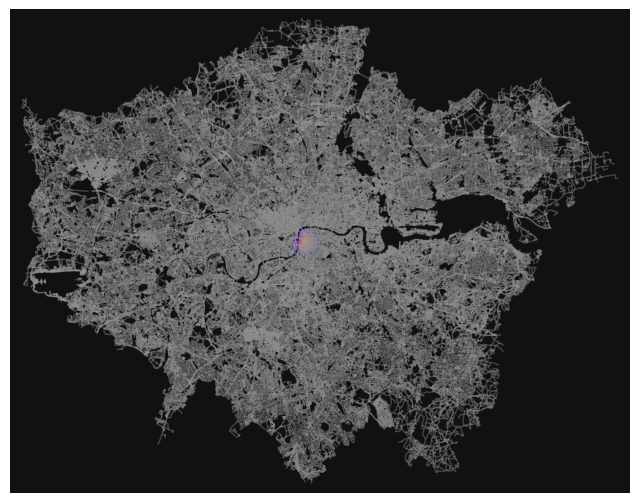

In [10]:
# plot the network then add isochrones as colored polygon patches
fig, ax = ox.plot.plot_graph(
    G,
    show=False,
    close=False,
    edge_color="#999999",
    edge_alpha=0.2,
    node_size=0,
)
gdf.plot(ax=ax, color=iso_colors, ec="none", alpha=0.6, zorder=-1)
plt.show()

## Or, plot isochrones as buffers to get more faithful isochrones than convex hulls can offer

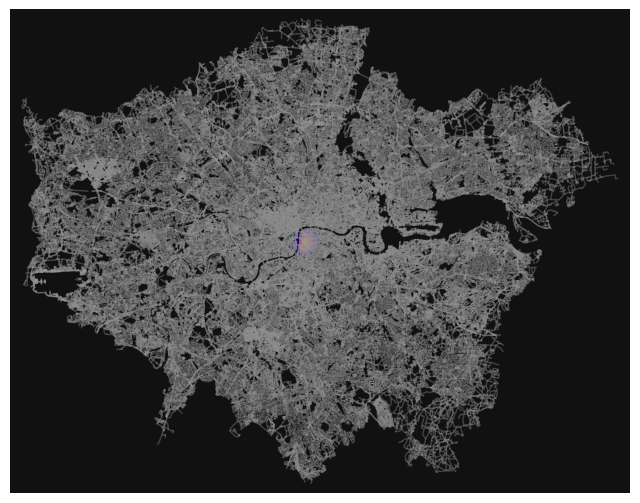

In [18]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")

        node_points = [
            Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)
        ]
        nodes_gdf = gpd.GeoDataFrame({"id": list(subgraph.nodes)}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index("id")

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get(
                "geometry", LineString([f, t])
            )
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).union_all()

        # try to fill in surrounded areas so shapes will appear solid and
        # blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys


# make the isochrone polygons
isochrone_polys = make_iso_polys(G, edge_buff=25, node_buff=0, infill=True)
gdf = gpd.GeoDataFrame(geometry=isochrone_polys)

# plot the network then add isochrones as colored polygon patches
fig, ax = ox.plot.plot_graph(
    G,
    show=False,
    close=False,
    edge_color="#999999",
    edge_alpha=0.2,
    node_size=0,
)
gdf.plot(ax=ax, color=iso_colors, ec="none", alpha=0.6, zorder=-1)
plt.show()

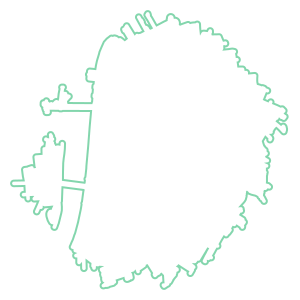

In [24]:
isochrone_polys[1].exterior

In [25]:
list(G.nodes)[0]

78112